In [69]:
import pandas as pd 
from sklearn.manifold import MDS
from scipy.spatial.distance import pdist, squareform
from sklearn.preprocessing import StandardScaler
from skbio.diversity import beta_diversity

Prepare the data. 

In [70]:
file_name = "Experimental_Structure_Data_05032025.xlsx"

fish = pd.read_excel(file_name, sheet_name='Fish')
relief = pd.read_excel(file_name, sheet_name='Relief')
species_codes = pd.read_excel(file_name, sheet_name='Species_Codes')

In [71]:
mean_relief= relief.groupby('Transect_Number')['Relief'].mean().reset_index(name='Mean_Relief')

mean_relief['Relief_Category'] = mean_relief['Mean_Relief'].apply(
    lambda x: 'High' if x >= 1.5 else 'Low'
)

In [72]:
fish_master = fish.merge(species_codes, on='Species', how='right')
fish_master = fish_master.merge(mean_relief, on = 'Transect_Number', how = 'right')

metadata = ['Date', 'Location', 'Recorder', 
                    'Buddy', 'Heading', 'Depth_ft', 'Unnamed: 13']

fish_master = fish_master.drop(columns=metadata)
fish_master

,Transect_Number,Treatment,Treatment_Time,Position,Species,Size_cm,Count,Species.1,Common_Name,Mobility,Mean_Relief,Relief_Category
0,2,Post-Kelp,1_hour,Benthic,SSER,25.0,1,RVAC,Olive rockfish,Intermediate,2.2,High
1,2,Pre-Kelp,0_hours,Mid-Column,SMYS,15.0,6,SATR,Blue rockfish,Midcolumn,2.2,High
2,2,Pre-Kelp,0_hours,Mid-Column,SMYS,20.0,6,EJAC,Blue rockfish,Midcolumn,2.2,High
3,2,Post-Kelp,1_hour,Mid-Column,SMYS,5.0,1,SMEL,Blue rockfish,Midcolumn,2.2,High
4,2,Post-Kelp,1_hour,Mid-Column,SMYS,15.0,4,NaN,Blue rockfish,Midcolumn,2.2,High
...,...,...,...,...,...,...,...,...,...,...,...,...
166,11,Post-Kelp,1_hour,NaN,HDEC,30.0,1,NaN,Kelp greenling,Benthic,1.5,High
167,11,Pre-Kelp,0_hours,NaN,OPIC,15.0,1,NaN,Painted greenling,Benthic,1.5,High
168,11,Post-Kelp,1_hour,NaN,OPIC,5.0,1,NaN,Painted greenling,Benthic,1.5,High
169,11,Pre-Kelp,0_hours,NaN,ELAT,15.0,11,NaN,Striped surfperch,Intermediate,1.5,High


Prepare data for Bray Curtis calculation. 

In [73]:
# Step 1: Aggregate the data by 'Transect_Number' and 'Species'
species_data = fish_master.pivot_table(index=['Transect_Number', 'Treatment_Time'],
                                       columns='Species', 
                                       values='Count', 
                                       aggfunc='sum', 
                                       fill_value=0)

# Step 2: Standardize the species count data
scaler = StandardScaler()
species_data_scaled = scaler.fit_transform(species_data)


Run nMDS. 

In [74]:
bray_curtis_distances = pdist(species_data_scaled, metric='braycurtis')
bray_curtis_square = squareform(bray_curtis_distances)

In [75]:
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
mds_coords = mds.fit_transform(bray_curtis_square)


mds_df = pd.DataFrame(mds_coords, columns=['MDS1', 'MDS2'])

mds_df['Treatment_Time'] = species_data.index.get_level_values('Treatment_Time').values


Calculate species vectors. 

In [76]:
species_vectors = pd.DataFrame(index=species_data.columns, columns=['r_MDS1', 'r_MDS2'])

for species in species_data.columns:
    species_vectors.loc[species, 'r_MDS1'] = np.corrcoef(species_data[species], mds_df['MDS1'])[0, 1]
    species_vectors.loc[species, 'r_MDS2'] = np.corrcoef(species_data[species], mds_df['MDS2'])[0, 1]

species_vectors = species_vectors.astype(float)


Define a function to plot ellipses. 

In [77]:
def plot_ellipse(x, y, ax, edgecolor='black', **kwargs):
    cov = np.cov(x, y)
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    
    # Eigen decomposition for ellipse axes
    eigvals, eigvecs = np.linalg.eigh(cov)
    order = eigvals.argsort()[::-1]
    eigvals, eigvecs = eigvals[order], eigvecs[:, order]
    
    angle = np.degrees(np.arctan2(*eigvecs[:,0][::-1]))
    width, height = 2 * np.sqrt(eigvals)  # 1 std dev ellipse

    ellipse = mpatches.Ellipse((mean_x, mean_y), width, height, angle=angle,
                               edgecolor=edgecolor, facecolor='none', lw=1.5, **kwargs)
    ax.add_patch(ellipse)


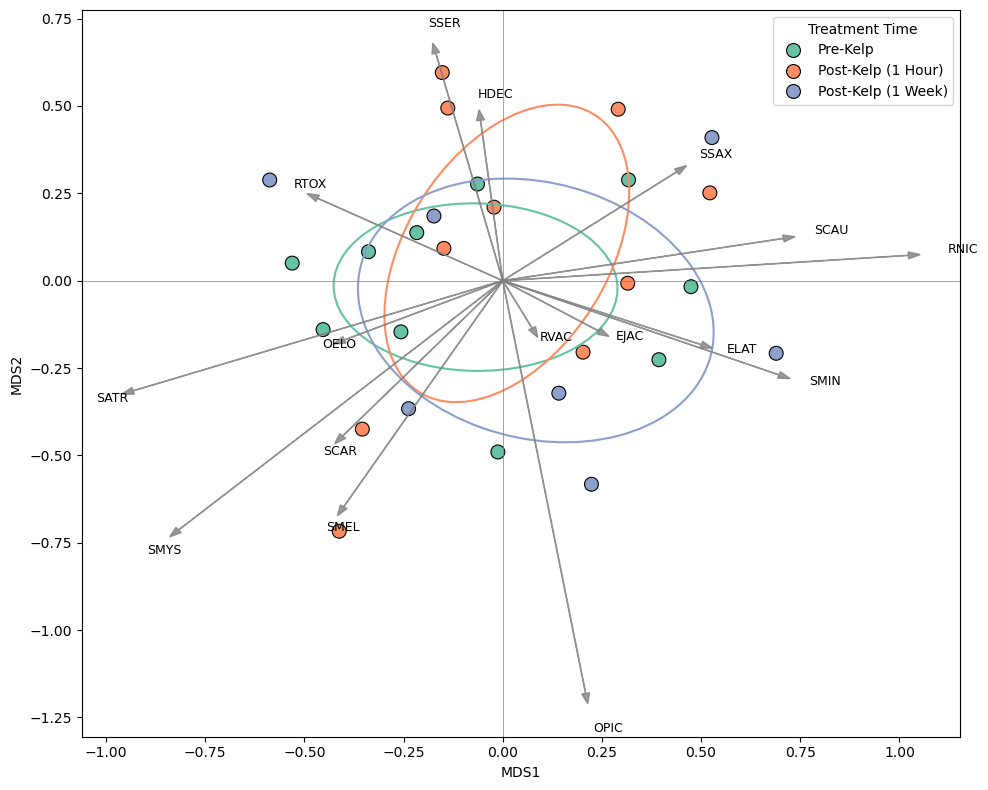

In [80]:
plt.figure(figsize=(10, 8))
ax = plt.gca()

# Plot MDS points, color-coded by 'Treatment_Time'
sns.scatterplot(data=mds_df, x='MDS1', y='MDS2', hue='Treatment_Time', palette='Set2', s=100, edgecolor='black', ax=ax)

# Add ellipses for each treatment group
for treatment in mds_df['Treatment_Time'].unique():
    subset = mds_df[mds_df['Treatment_Time'] == treatment]
    if len(subset) >= 3:  # Need at least 3 points to define an ellipse
        plot_ellipse(subset['MDS1'], subset['MDS2'], ax,
                     edgecolor=sns.color_palette('Set2')[list(mds_df['Treatment_Time'].unique()).index(treatment)])

# Plot species vectors for top species
for species, row in species_vectors.iterrows():
    ax.arrow(0, 0, row['r_MDS1'] * 1.5, row['r_MDS2'] * 1.5,
             color='gray', alpha=0.8, head_width=0.02, length_includes_head=True)
    ax.text(row['r_MDS1'] * 1.6, row['r_MDS2'] * 1.6, species, fontsize=9)

# Add axis lines
ax.axhline(0, color='gray', lw=0.5)
ax.axvline(0, color='gray', lw=0.5)

# Customize the legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles=handles, labels=['Pre-Kelp', 'Post-Kelp (1 Hour)', 'Post-Kelp (1 Week)'], title='Treatment Time')

plt.tight_layout()

# Ensure 'plots/' folder exists
import os
os.makedirs("plots", exist_ok=True)

# Save the figure
plt.savefig("plots/mds_plot.jpeg", format='jpeg', dpi=300)

# Show the plot
plt.show()
